In [6]:
using CSV, Tables, LinearAlgebra, Random, Gurobi, JuMP, DataFrames, Statistics, MLJ, Plots, Clustering, Distances
include("kmeans.jl")

euclidean_warm_start (generic function with 1 method)

In [9]:
#I,J,D = 3, 100, 2
#std = [1,2,3]

points = generate_points(2,50,2, [2,3]);
centroids, assignment, obj_value = manhattan_optimal_kmenas(points, 2,50,2);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 850 rows, 554 columns and 2000 nonzeros
Model fingerprint: 0xc586e9f5
Variable types: 454 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 2e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 413 rows and 305 columns
Presolve time: 0.00s
Presolved: 437 rows, 249 columns, 1027 nonzeros
Variable types: 199 continuous, 50 integer (50 binary)
Found heuristic solution: objective 19.1356579

Root relaxation: objective -2.890918e+01, 266 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

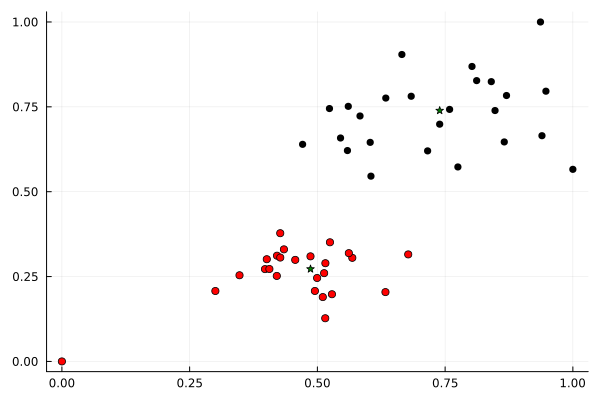

In [11]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [14]:
points = generate_points(4,300,2, [1,1,2,2]);
centroids, assignment, obj_value = manhattan_optimal_kmenas(points, 4,300,2);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9900 rows, 6308 columns and 24000 nonzeros
Model fingerprint: 0x970434a7
Variable types: 5108 continuous, 1200 integer (1200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 1e+00]
Found heuristic solution: objective 135.6625421
Presolve removed 3624 rows and 2412 columns
Presolve time: 0.02s
Presolved: 6276 rows, 3896 columns, 15552 nonzeros
Found heuristic solution: objective 126.4665663
Variable types: 2696 continuous, 1200 integer (1200 binary)

Root relaxation: objective -2.158277e+02, 3988 iterations, 0.12 seconds (0.25 work units)

    Nodes    |    Cu

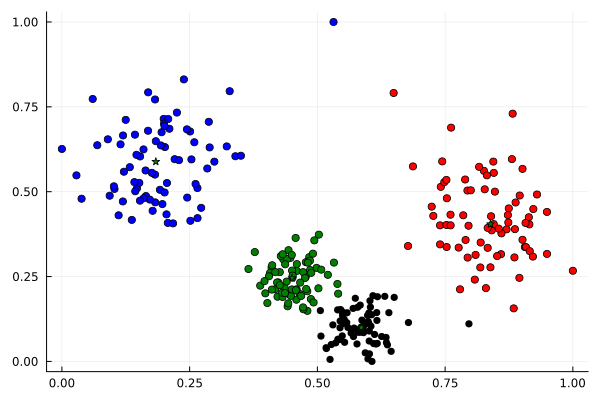

In [15]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue, 4=>:green)
colors = [mapping[v] for v in assignment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

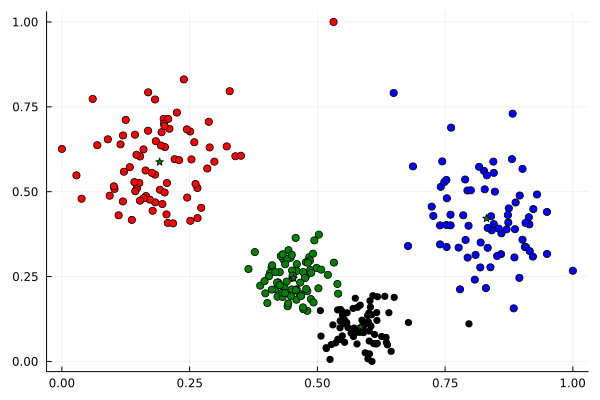

In [16]:
km = kmeans(points', 4);
centroids = km.centers';
assignments = km.assignments;

mapping = Dict(1=>:black, 2=>:red, 3=>:blue, 4=>:green)
colors = [mapping[v] for v in assignments];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)

plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [17]:
centroids, assignment, obj_value = manhattan_warm_start(points, 4,300,2);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9900 rows, 6308 columns and 24000 nonzeros
Model fingerprint: 0x56f925a1
Variable types: 5108 continuous, 1200 integer (1200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-03, 1e+00]

User MIP start produced solution with objective 33.7349 (0.01s)
Loaded user MIP start with objective 33.7349

Presolve removed 3624 rows and 2412 columns
Presolve time: 0.01s
Presolved: 6276 rows, 3896 columns, 15552 nonzeros
Variable types: 2696 continuous, 1200 integer (1200 binary)

Root relaxation: objective -2.158277e+02, 3988 iterations, 0.14 seconds (0.25 work units)

    N

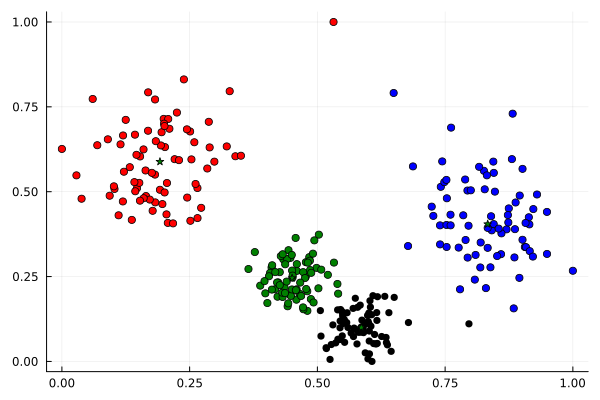

In [18]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue, 4=>:green)
colors = [mapping[v] for v in assignment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

#### Easy problem

In [ ]:
points = generate_points(4,50,2, [0.8,1,0.5, 0.3]);
centroids,  assignment, obj_value = manhattan_optimal_kmenas(points, 4,50,2);

In [ ]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue, 4=>:green)
colors = [mapping[v] for v in assignment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [ ]:
centroids, assignment, obj_value = euclidean_optimal_kmenas(points, 4,50,2);

In [ ]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue, 4=>:green)
colors = [mapping[v] for v in assignment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [ ]:
km = kmeans(points', 4);
centroids = km.centers';
assignments = km.assignments;
r = km.counts;

mapping = Dict(1=>:black, 2=>:red, 3=>:blue, 4=>:green)
colors = [mapping[v] for v in assignments];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)

plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [ ]:
x = 1
for i = 1:4
    x += 1
end
x

In [ ]:
counts([2,1,1,1,3])

### Results

In [ ]:
euclidean = ones((4,1))
manhattan = ones((4,1))
x,y = 1,1

for point = [10,25,50,100]
    for clusters  = [2]
        points = generate_points(clusters,point,2, ones(clusters)*2);
        centroids,  assignment, obj_value = manhattan_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        manhattan[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment, obj_value = euclidean_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        euclidean[x,y] = mean_silhouette_score(assignment, c, points);
        y+=1;
    end
    x+=1;
    y=1;
end

In [ ]:
euclidean

In [ ]:
manhattan

In [ ]:
km = ones((4,1))
x,y = 1,1

for point = [10,25,50,100]
    for clusters  = [2]
        points = generate_points(clusters,point,2, ones(clusters)*2);
        centroids,  assignment,c = kmeans(points', clusters).centers, kmeans(points', clusters).assignments, kmeans(points', clusters).counts;
        dd = pairwise(SqEuclidean(), points')
        km[x,y] = mean(silhouettes(assignment, c, dd));
        y+=1;
    end
    x+=1;
    y=1;
end

In [ ]:
km

In [ ]:
euclidean = ones((4,1))
manhattan = ones((4,1))
km = ones((4,1))
x,y = 1,1

for point = [10,25,50,100]
    for clusters  = [3]
        points = generate_points(clusters,point,2, ones(clusters)*2);
        centroids,  assignment, obj_value = manhattan_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        manhattan[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment, obj_value = euclidean_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        euclidean[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment,c = kmeans(points', clusters).centers, kmeans(points', clusters).assignments, kmeans(points', clusters).counts;
        dd = pairwise(SqEuclidean(), points')
        km[x,y] = mean(silhouettes(assignment, c, dd));
        y+=1;
    end
    x+=1;
    y=1;
end

In [ ]:
euclidean

In [ ]:
manhattan

In [ ]:
km

In [ ]:
euclidean = ones((4,1))
manhattan = ones((4,1))
km = ones((4,1))
x,y = 1,1

for point = [10,25,50,100]
    for clusters  = [4]
        points = generate_points(clusters,point,2, ones(clusters)*2);
        centroids,  assignment, obj_value = manhattan_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        manhattan[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment, obj_value = euclidean_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        euclidean[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment,c = kmeans(points', clusters).centers, kmeans(points', clusters).assignments, kmeans(points', clusters).counts;
        dd = pairwise(SqEuclidean(), points')
        km[x,y] = mean(silhouettes(assignment, c, dd));
        y+=1;
    end
    x+=1;
    y=1;
end

In [ ]:
euclidean

In [ ]:
manhattan

In [ ]:
km

In [ ]:
euclidean = ones((4,1))
manhattan = ones((4,1))
km = ones((4,1))
x,y = 1,1

for point = [200,300]
    for clusters  = [4]
        points = generate_points(clusters,point,2, ones(clusters)*2);
        centroids,  assignment, obj_value = manhattan_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        manhattan[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment, obj_value = euclidean_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        euclidean[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment,c = kmeans(points', clusters).centers, kmeans(points', clusters).assignments, kmeans(points', clusters).counts;
        dd = pairwise(SqEuclidean(), points')
        km[x,y] = mean(silhouettes(assignment, c, dd));
        y+=1;
    end
    x+=1;
    y=1;
end

In [ ]:
euclidean[1:2]

In [ ]:
manhattan[1:2]

In [ ]:
km[1:2]

In [ ]:
points = generate_points(3,50,2, [4,4,4]);
centroids, assignment, obj_value = manhattan_optimal_kmenas(points, 3,50,2);

In [ ]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [21]:
a = Matrix(CSV.read("results/dim2_optimal_euclidean_performance.csv", DataFrame))
b = Matrix(CSV.read("results/dim2_optimal_manhattan_performance.csv", DataFrame))
c = Matrix(CSV.read("results/dim2_kmeans_performance.csv", DataFrame))
d = Matrix(CSV.read("results/dim2_warm_start_euclidean_performance.csv", DataFrame))
e = Matrix(CSV.read("results/dim2_warm_start_manhattan_performance.csv", DataFrame));

In [37]:
b .< e


4×6 BitMatrix:
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  1  0  0  0
 0  0  1  1  1  0